# DISCERN:  Noise Reduction and Diagnosis for Chest X-rays

In [2]:
!pip install opencv-python-headless

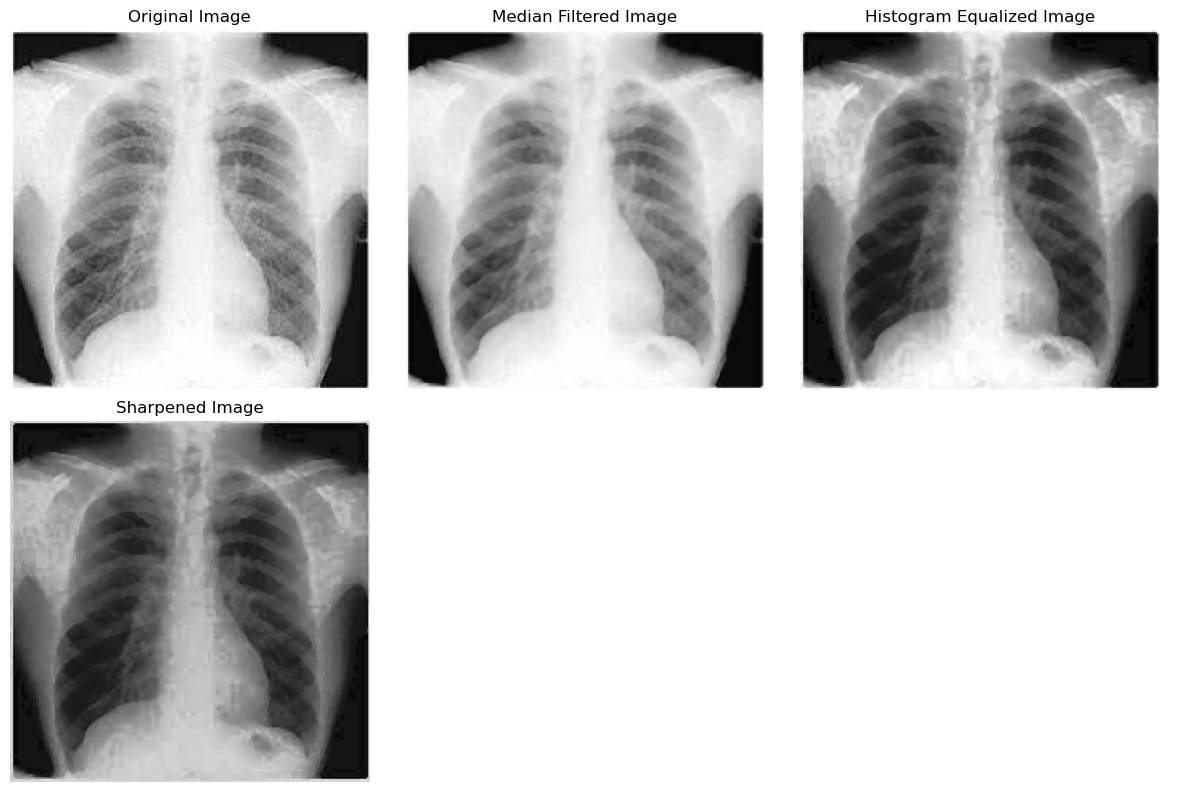

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters, restoration

# Load chest X-ray image
image = cv2.imread(r'C:\Users\Asus\Downloads\xray.jpg', cv2.IMREAD_GRAYSCALE)

# Apply median filter to remove salt-and-pepper noise
denoised_image = cv2.medianBlur(image, 3)

# Apply histogram equalization to enhance contrast
equalized_image = exposure.equalize_hist(denoised_image)

# Apply unsharp masking to sharpen image
blurred_image = cv2.GaussianBlur(equalized_image, (3, 3), 0)
sharpened_image = cv2.addWeighted(equalized_image, 1.5, blurred_image, -0.5, 0)

# # Apply Wiener filter to remove Gaussian noise
# psf = np.ones((5, 5)) / 25
# gaussian_noise = np.random.normal(0, 0.1, image.shape)
# noisy_image = np.clip(image + gaussian_noise, 0, 1)
# wiener_image = restoration.wiener(noisy_image, psf, 0.1)

# Display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(denoised_image, cmap='gray')
ax[1].set_title('Median Filtered Image')

ax[2].imshow(equalized_image, cmap='gray')
ax[2].set_title('Histogram Equalized Image')

ax[3].imshow(sharpened_image, cmap='gray')
ax[3].set_title('Sharpened Image')

# ax[4].imshow(noisy_image, cmap='gray', vmin=0, vmax=1)
# ax[4].set_title('Noisy Image')

# ax[5].imshow(wiener_image, cmap='gray', vmin=0, vmax=1)
# ax[5].set_title('Wiener Filtered Image')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [4]:
class cfg:
    IMAGE_SIZE = 128

    # Data Augmentation
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST   = (0.64, 1.37) # (MIN, MAX)

    # Train-Val Split
    TRAIN_VAL_SPLIT = 0.8 # 80% of all the samples are used for training, and the rest for validation

    # Model Training
    BATCH_SIZE = 8
    EPOCHS = 8
    LEARNING_RATE = 0.0009



In [5]:
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()

In [4]:
pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 7.9 MB/s eta 0:00:00
     -------------------------------------- 57.5/57.5 kB 761.8 kB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 7.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 65.5/65.5 kB 1.2 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 7.8 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 7.4 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 6.7 MB/s eta 0:00:00
     -------------------------------

In [6]:
tf.random.set_seed(100)
np.random.seed(100)

In [7]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [8]:
data_directories = ['C:/Users/Asus/OneDrive/Desktop/Dataset/test/',
                    'C:/Users/Asus/OneDrive/Desktop/Dataset/train/',
                    'C:/Users/Asus/OneDrive/Desktop/Dataset/val/']

all_paths = []
all_labels = []

for data_dir in data_directories:
    for label in os.listdir(data_dir):
        for image in os.listdir(data_dir+label):
            all_paths.append(data_dir+label+'/'+image)
            if label=='TURBERCULOSIS':
                all_labels.append('TUBERCULOSIS')
            else:
                all_labels.append(label)

all_paths, all_labels = shuffle(all_paths, all_labels)

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':all_paths, 'label':all_labels})
df

,path,label
0,C:/Users/Asus/OneDrive/Desktop/Dataset/train/NORMAL/NORMAL2-IM-0799-0001.jpeg,NORMAL
1,C:/Users/Asus/OneDrive/Desktop/Dataset/train/PNEUMONIA/person1036_bacteria_2970.jpeg,PNEUMONIA
2,C:/Users/Asus/OneDrive/Desktop/Dataset/train/PNEUMONIA/person1474_virus_2556.jpeg,PNEUMONIA
3,C:/Users/Asus/OneDrive/Desktop/Dataset/train/PNEUMONIA/person1550_virus_2691.jpeg,PNEUMONIA
4,C:/Users/Asus/OneDrive/Desktop/Dataset/train/TUBERCULOSIS/Tuberculosis-530.png,TUBERCULOSIS
...,...,...
7130,C:/Users/Asus/OneDrive/Desktop/Dataset/test/COVID19/COVID19(539).jpg,COVID19
7131,C:/Users/Asus/OneDrive/Desktop/Dataset/train/PNEUMONIA/person1634_bacteria_4331.jpeg,PNEUMONIA
7132,C:/Users/Asus/OneDrive/Desktop/Dataset/train/PNEUMONIA/person721_virus_1340.jpeg,PNEUMONIA
7133,C:/Users/Asus/OneDrive/Desktop/Dataset/train/TUBERCULOSIS/Tuberculosis-54.png,TUBERCULOSIS


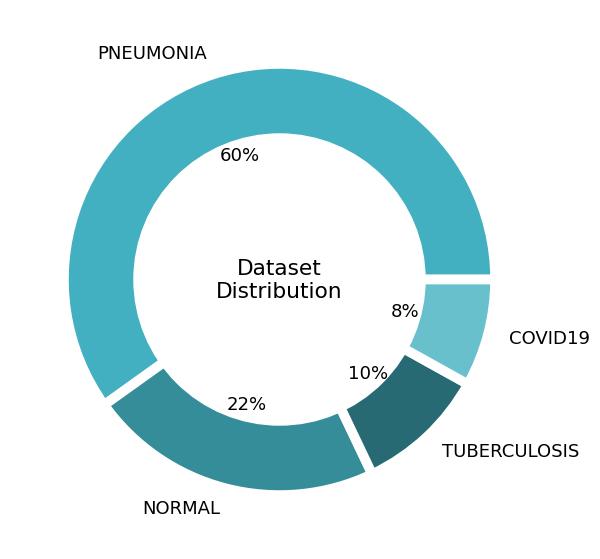

In [9]:
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(7,7))

# plotting data on chart
plt.pie(list(df.label.value_counts()),
        labels=list(df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Dataset\nDistribution', x=0.5, y=0.45) 
plt.show()

In [10]:
def augment_image(image):
    # Convert input image from numpy to PIL Image
    image = Image.fromarray(np.uint8(image)) 
    # Select brightness and contrast factors
    brightness_factor = random.uniform(cfg.BRIGHTNESS[0],cfg.BRIGHTNESS[1])
    contrast_factor = random.uniform(cfg.CONTRAST[0],cfg.CONTRAST[1])
    # Apply Transformations
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    return image

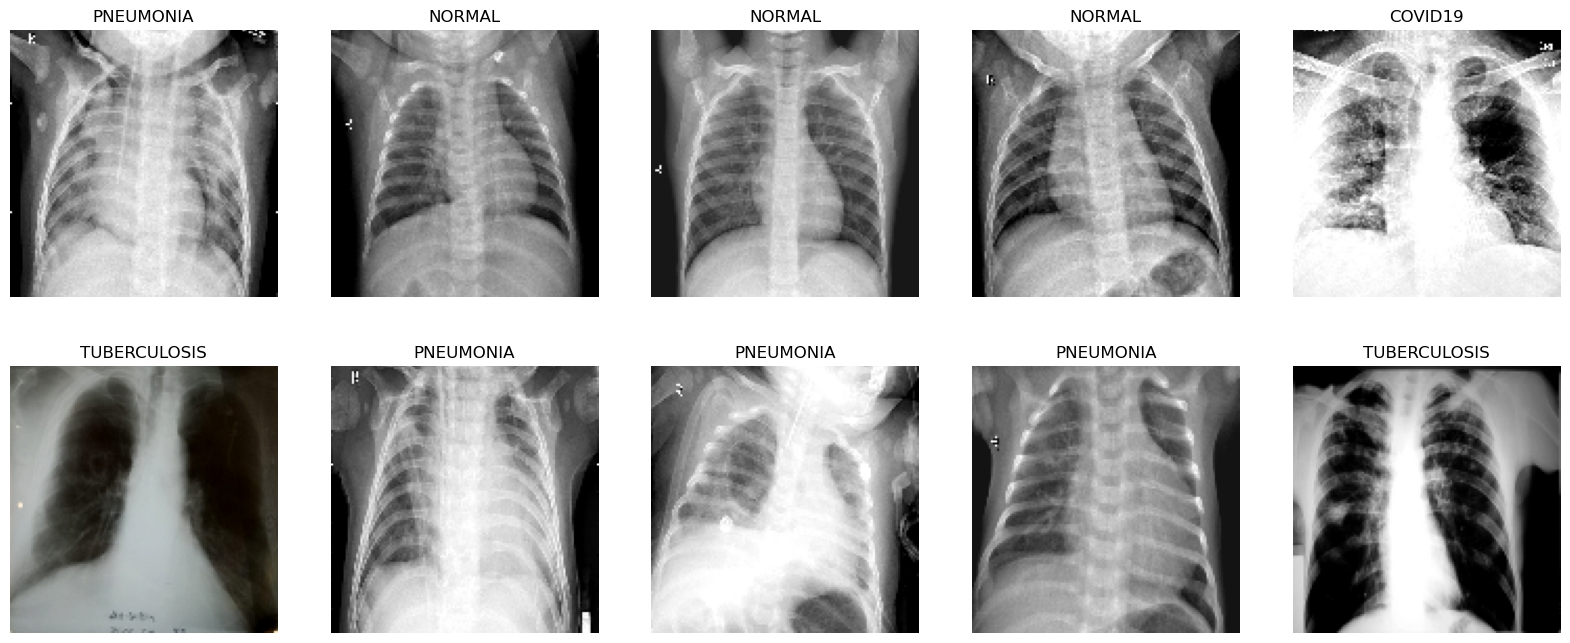

In [11]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(cfg.IMAGE_SIZE,cfg.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(df.path[k:k+10])
labels = list(df.label[k:k+10])
images = open_images(image_paths, augment=True)

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()


In [12]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID19'}

In [13]:
df_train = df[:int(cfg.TRAIN_VAL_SPLIT*len(df))]
df_val = df[int(cfg.TRAIN_VAL_SPLIT*len(df)):]

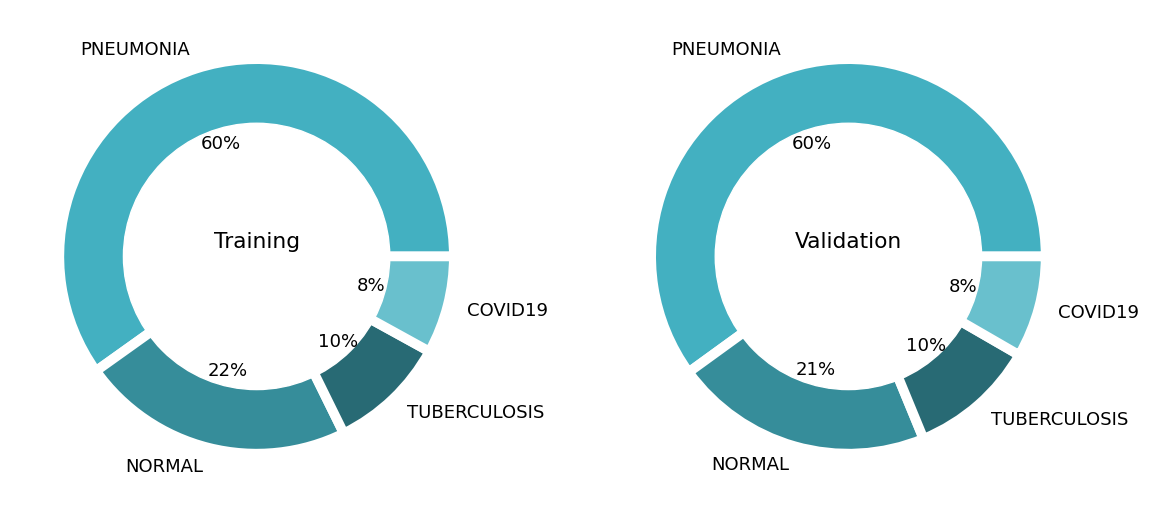

In [14]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 2, 1)
plt.pie(list(df_train.label.value_counts()),
        labels=list(df_train.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 2, 2)
plt.pie(list(df_val.label.value_counts()),
        labels=list(df_val.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

plt.show()

In [15]:
def data_generator(df, batch_size=cfg.BATCH_SIZE, augment=True, epochs=cfg.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [16]:
train_data_generator = data_generator(df_train, batch_size=cfg.BATCH_SIZE, augment=True, epochs=cfg.EPOCHS)
train_steps = int(len(df_train)/cfg.BATCH_SIZE)

val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE, augment=False, epochs=cfg.EPOCHS)
val_steps = int(len(df_val)/cfg.BATCH_SIZE)

In [17]:
model = models.Sequential(name='classifier')
model.add(layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3), name='input'))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv1'))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool1'))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv1'))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool2'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv1'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool3'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dropout(0.3, name='dropout1'))
model.add(layers.Dense(128, activation='relu', name='dense1'))
model.add(layers.Dense(4, activation='softmax', name='final'))

model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 32)      896       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 32)      9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 64)        18496     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 block3_conv1 (Conv2D)       (None, 32, 32, 128)       7

In [18]:
model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [19]:
class_weights = (df_train.label.value_counts() / len(df_train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{2: 0.5986334968465312,
 0: 0.22424667133847231,
 1: 0.09705676243868255,
 3: 0.08006306937631394}

In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='C:/Users/Asus/OneDrive/Desktop/Dataset/model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history = model.fit(train_data_generator, epochs=cfg.EPOCHS, steps_per_epoch=train_steps, class_weight=class_weights,
          validation_data=val_data_generator, validation_steps=val_steps, callbacks=[model_checkpoint_callback])

Epoch 1/8
  1/713 [..............................] - ETA: 15:14:20 - loss: 0.6733 - accuracy: 0.1250

KeyboardInterrupt: 

In [21]:
val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(df_val)/cfg.BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

     COVID19     0.0000    0.0000    0.0000       119
      NORMAL     0.0000    0.0000    0.0000       303
   PNEUMONIA     0.5999    1.0000    0.7499       856
TUBERCULOSIS     0.0000    0.0000    0.0000       149

    accuracy                         0.5999      1427
   macro avg     0.1500    0.2500    0.1875      1427
weighted avg     0.3598    0.5999    0.4498      1427



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



1/1 [==============================] - 0s 157ms/step


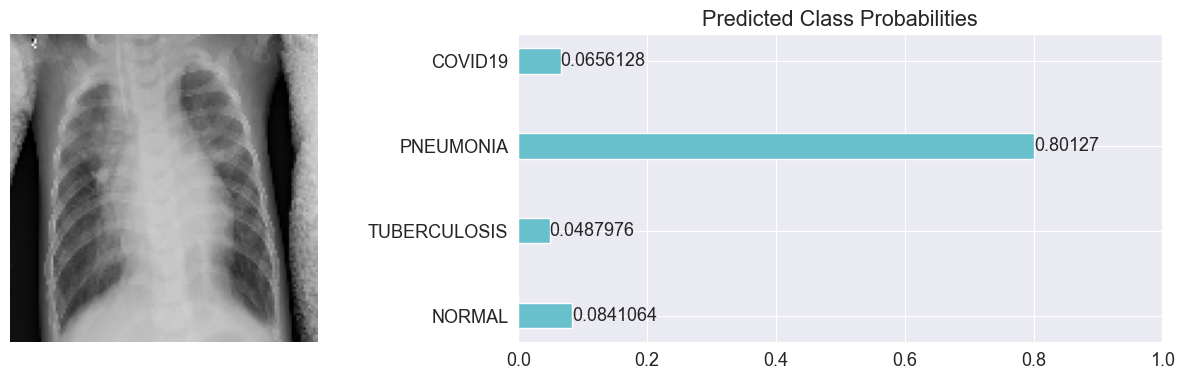

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 165ms/step


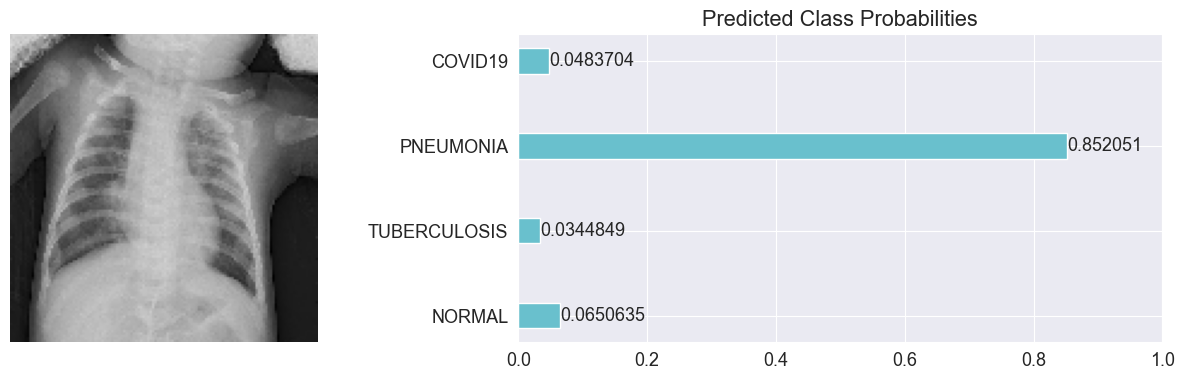

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 180ms/step


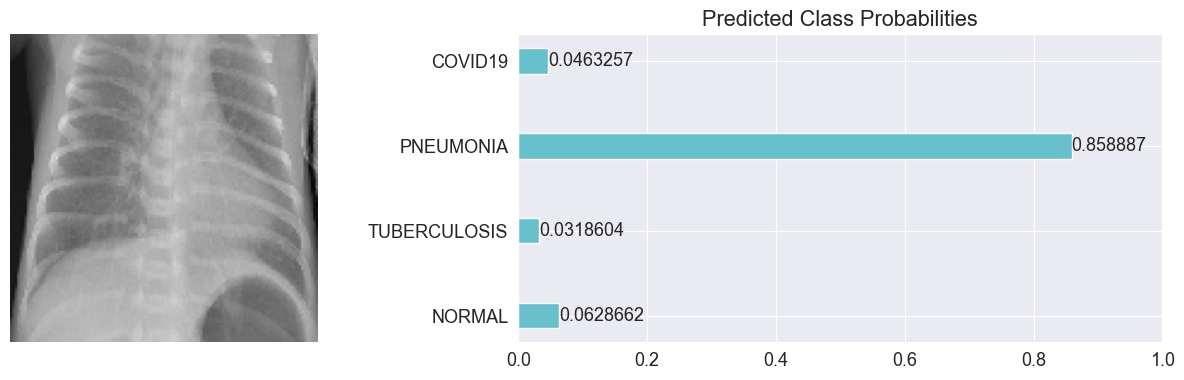

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 173ms/step


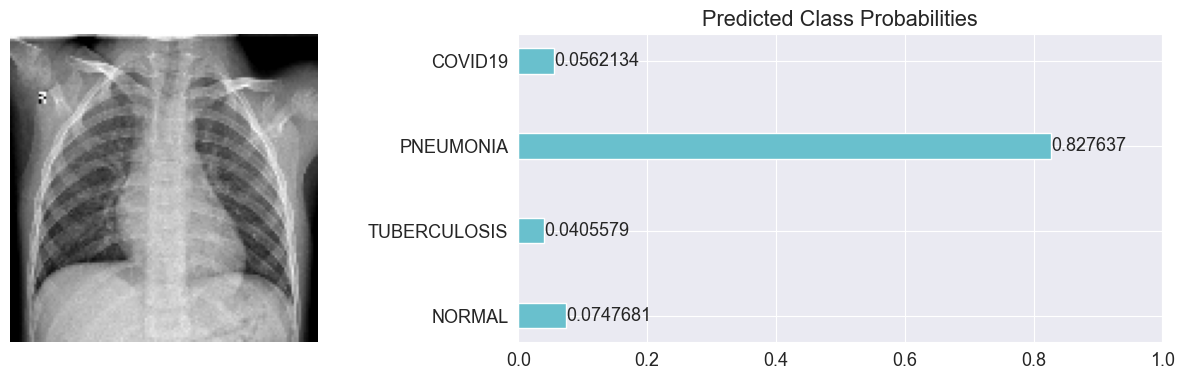

Actual   : NORMAL
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 179ms/step


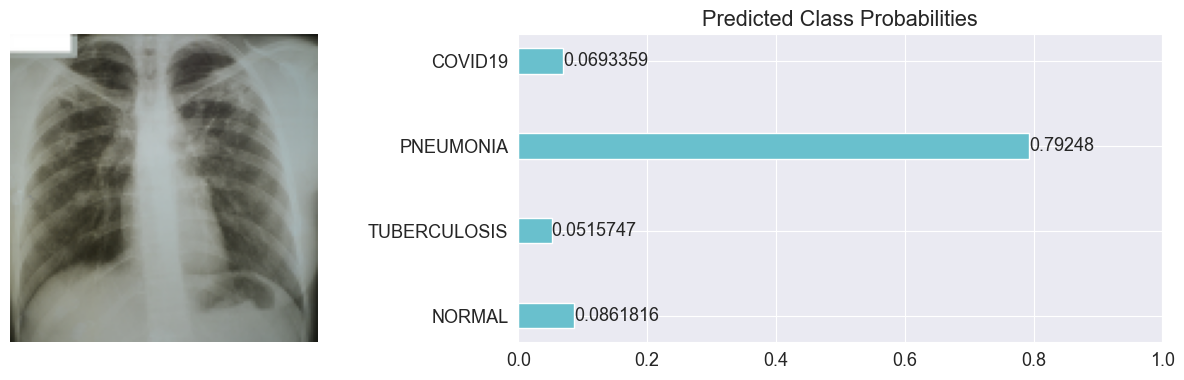

Actual   : TUBERCULOSIS
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 152ms/step


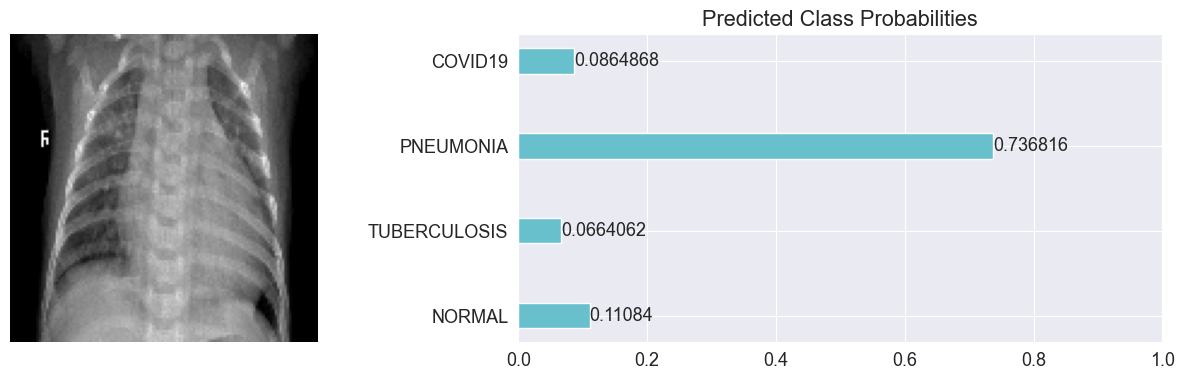

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 152ms/step


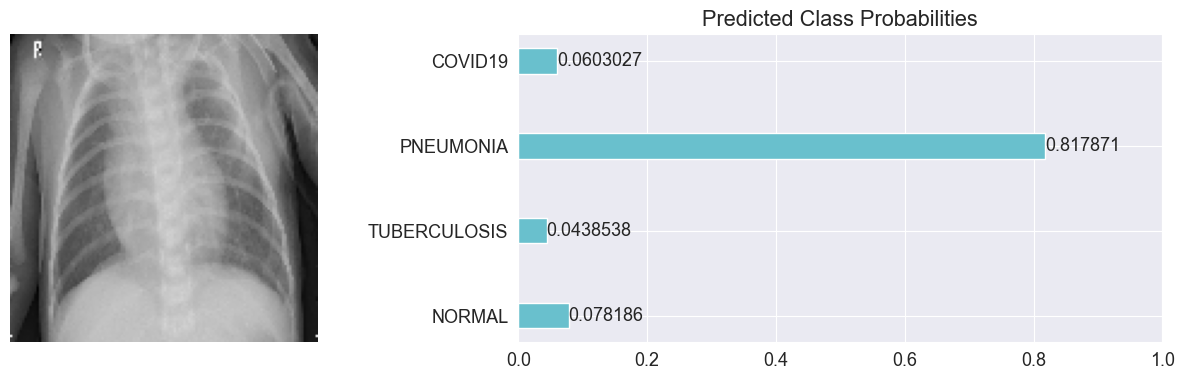

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------




In [22]:
def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,cfg.IMAGE_SIZE,cfg.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(df.index), 7)

for INDEX in INDICES:

    image = load_img(df.path[INDEX], target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)
    
    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')

In [23]:
df_train = df[:int(cfg.TRAIN_VAL_SPLIT*len(df))]
df_val = df[int(cfg.TRAIN_VAL_SPLIT*len(df)):]

In [24]:
import gradio as gr

import tensorflow as tf
import os
import numpy as np

model = tf.keras.models.load_model('model.hdf5')

LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']

def predict_input_image(img):
  img_4d=img.reshape(-1,128,128,3)/255.0
  print(img_4d.min())
  print(img_4d.max())
  prediction=model.predict(img_4d)[0]
  return {LABELS[i]: float(prediction[i]) for i in range(4)}

def k():
  return gr.update(value=None)

with gr.Blocks(title="Chest X-Ray Disease Classification", css="") as demo:
  with gr.Row():
    textmd = gr.Markdown('''
    # Chest X-Ray Disease Classification
    View the full training code at <a href="https://www.kaggle.com/code/mushfirat/chest-x-ray-disease-classification"><b>kaggle</b></a> 
    ''')
  with gr.Row():
    with gr.Column(scale=1, min_width=600):
      image = gr.inputs.Image(shape=(128,128))
      with gr.Row():
        clear_btn = gr.Button("Clear")
        submit_btn = gr.Button("Submit", elem_id="warningk", variant='primary')
      examples = gr.Examples(examples=["COVID19-0.jpg",
                                       "NORMAL-0.jpeg",
                                       "COVID19-1.jpg",
                                       "PNEUMONIA-0.jpeg"], inputs=image)
    label = gr.outputs.Label(num_top_classes=4)
    
    clear_btn.click(k, inputs=[], outputs=image)
    submit_btn.click(predict_input_image, inputs=image, outputs=label)

demo.launch()

OSError: No file or directory found at model.hdf5

In [25]:
import gradio as gr
import tensorflow as tf
import cv2
import numpy as np
from skimage import exposure

# Load the pre-trained model
model = tf.keras.models.load_model('C:/Users/Asus/OneDrive/Desktop/Dataset/model.hdf5')

# Define the labels for classification
labels = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']

# Function to predict label given an image
def predict(input_image):
    img_4d=input_image.reshape(-1,128,128,3)/255.0
    print(img_4d.min())
    print(img_4d.max())
    prediction=model.predict(img_4d)[0]
    return {LABELS[i]: float(prediction[i]) for i in range(4)}

def noise_filter(input_image):
    image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.medianBlur(image, 3)
    equalized_image = exposure.equalize_hist(denoised_image)
    blurred_image = cv2.GaussianBlur(equalized_image, (3, 3), 0)
    sharpened_image = cv2.addWeighted(equalized_image, 1.5, blurred_image, -0.5, 0)
    # Normalize the image to the range [-1, 1]

    normalized_image = (sharpened_image - sharpened_image.min()) / (sharpened_image.max() - sharpened_image.min())
    
    resized_image = cv2.resize(normalized_image, (200, 200))
    
    return resized_image
#     return normalized_image

# Set up the Gradio interface
inputs = gr.inputs.Image(shape=(128, 128))
outputs = gr.outputs.Label(num_top_classes=4)
# filtered_image = gr.outputs.Image(type="numpy",label="Filtered Image")


filtered_image = gr.outputs.Image(type="numpy", label="Filtered Image")

interface = gr.Interface(predict, inputs=inputs, outputs=outputs)
interface1 = gr.Interface(noise_filter, inputs=inputs, outputs=filtered_image)

demo1= gr.Parallel(interface,interface1)

# interface.launch()
demo1.launch(share=True)

C:\Users\Asus\anaconda3\lib\site-packages\gradio\inputs.py:257: UserWarning:

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components

C:\Users\Asus\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning:

`optional` parameter is deprecated, and it has no effect

C:\Users\Asus\anaconda3\lib\site-packages\gradio\outputs.py:197: UserWarning:

Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components

C:\Users\Asus\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning:

The 'type' parameter has been deprecated. Use the Number component instead.

C:\Users\Asus\anaconda3\lib\site-packages\gradio\outputs.py:43: UserWarning:

Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components



Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app


0.011764705882352941
1.0
1/1 [==============================] - 1s 503ms/step
0.0
0.9568627450980393
1/1 [==============================] - 0s 222ms/step
0.0
0.6666666666666666
1/1 [==============================] - 0s 167ms/step
0.0
0.7098039215686275
1/1 [==============================] - 0s 180ms/step
0.12549019607843137
0.7294117647058823
1/1 [==============================] - 0s 217ms/step
0.13725490196078433
0.8156862745098039
1/1 [==============================] - 0s 250ms/step
0.21176470588235294
0.7686274509803922
1/1 [==============================] - 0s 201ms/step
0.0
0.8509803921568627
1/1 [==============================] - 0s 169ms/step
0.0
0.8509803921568627
1/1 [==============================] - 0s 166ms/step
0.0
0.9058823529411765
1/1 [==============================] - 0s 248ms/step
0.00784313725490196
0.8431372549019608
1/1 [==============================] - 0s 200ms/step
0.0
0.9686274509803922
1/1 [==============================] - 0s 216ms/step
0.0
0.8901960784313725